In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path1 = "/content/drive/MyDrive/google_trends.csv"
path2  = '/content/drive/MyDrive/tickers.csv'
trends = pd.read_csv(path1)
stocks = pd.read_csv(path2)

stocks.drop(columns=["CVG.Close"], inplace=True)

trends = trends.replace("<1", 0)

trends = trends.loc[:, (trends != 0).any(axis=0)]

trends['date'] = pd.to_datetime(trends['date'])
trends['week_start'] = trends['date'] - pd.to_timedelta(6, unit='d')
alldates = trends.assign(dates=trends.apply(lambda x: pd.date_range(x['week_start'], x['date'], freq='D'), axis=1)).explode('dates')

alldates['dates'] = pd.to_datetime(alldates['dates'])
column_names = alldates.columns[2:12]
alldates[column_names] = alldates[column_names].apply(pd.to_numeric)
alldates = alldates.drop(columns=['date', 'week_start']).rename(columns={'dates': 'date'})

stocks['date'] = pd.to_datetime(stocks['date'])

alldata = stocks.merge(alldates, on='date')

stocks_cl = alldata.iloc[:, :9]
trends_cl = alldata.iloc[:, [0] + list(range(9, len(alldata.columns)))]

# Melt the columns of the stocks_cl dataframe except for the date column

stocks_cl.reset_index(inplace=True)
stocks_cl['period'] = stocks_cl.index.values

melted_stocks = pd.melt(stocks_cl[stocks_cl.drop(columns=['date', 'index']).columns], id_vars=['period'], var_name='stock', value_name='value')

melted_stocks = melted_stocks.sort_values(by='period')

melted_stocks = melted_stocks.reset_index(drop=True)

# Melt the columns of the trends_cl dataframe except for the date column

trends_cl.reset_index(inplace=True)
trends_cl['period'] = trends_cl.index.values

melted_trends = pd.melt(trends_cl[trends_cl.drop(columns=['date', 'index']).columns], id_vars=['period'], var_name='trend', value_name='value')

melted_trends = melted_trends.sort_values(by='period')

melted_trends['value'] = pd.to_numeric(melted_trends['value'])



<ipython-input-11-c32300104400>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_cl['period'] = trends_cl.index.values


In [ ]:
trends_cl = trends_cl[trends_cl.drop(columns=['index', 'period']).columns]

stocks_cl = stocks_cl[stocks_cl.drop(columns=['index', 'period']).columns]



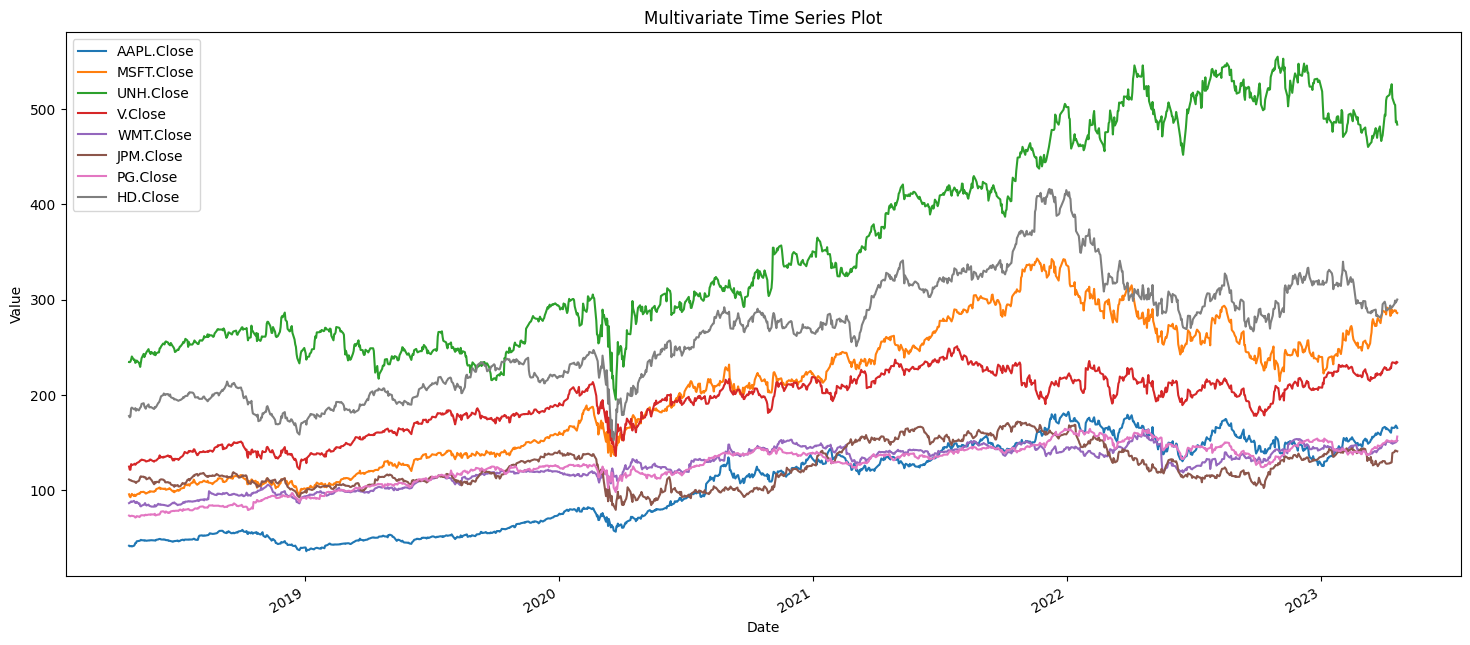

In [ ]:
# Plot stocks over time
stocks_cl.set_index('date', inplace=True)

ax = stocks_cl.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Multivariate Time Series Plot')

# Show the plot
plt.show()

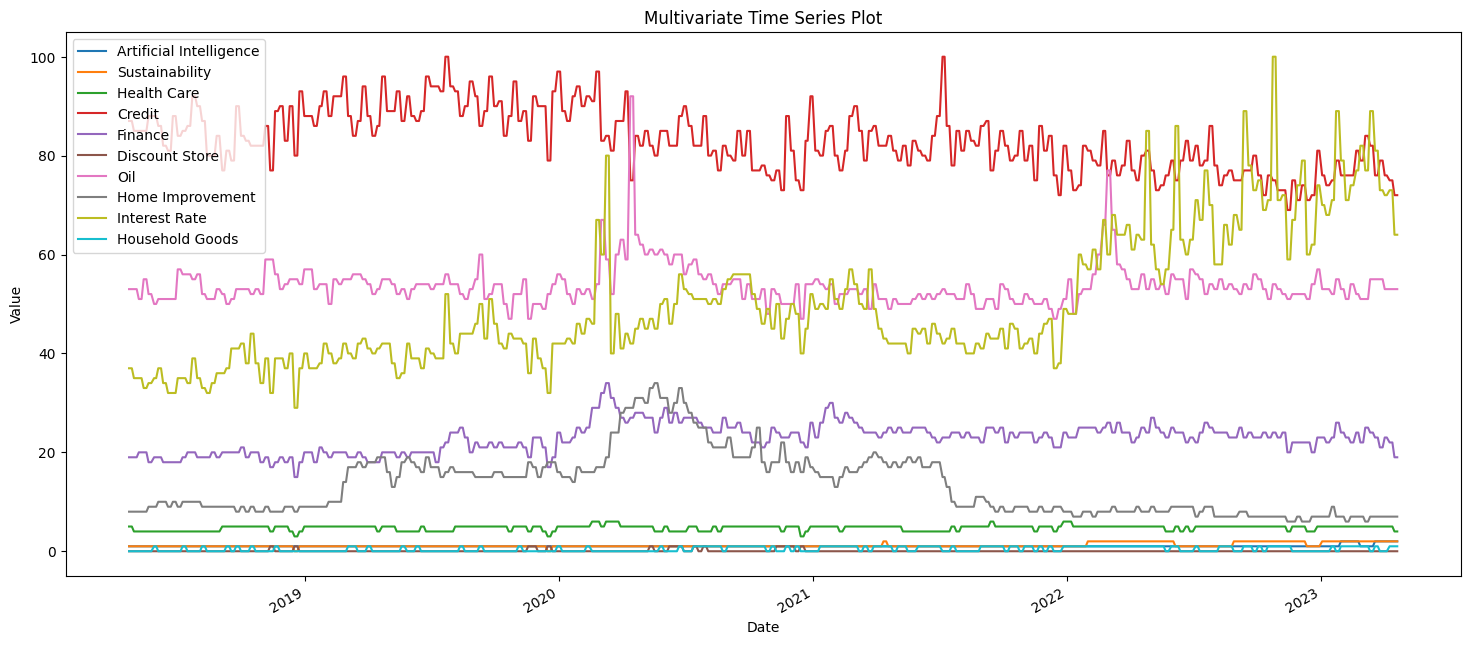

In [ ]:
# Plot stocks over time
trends_cl.set_index('date', inplace=True)

ax = trends_cl.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Multivariate Time Series Plot')

# Show the plot
plt.show()



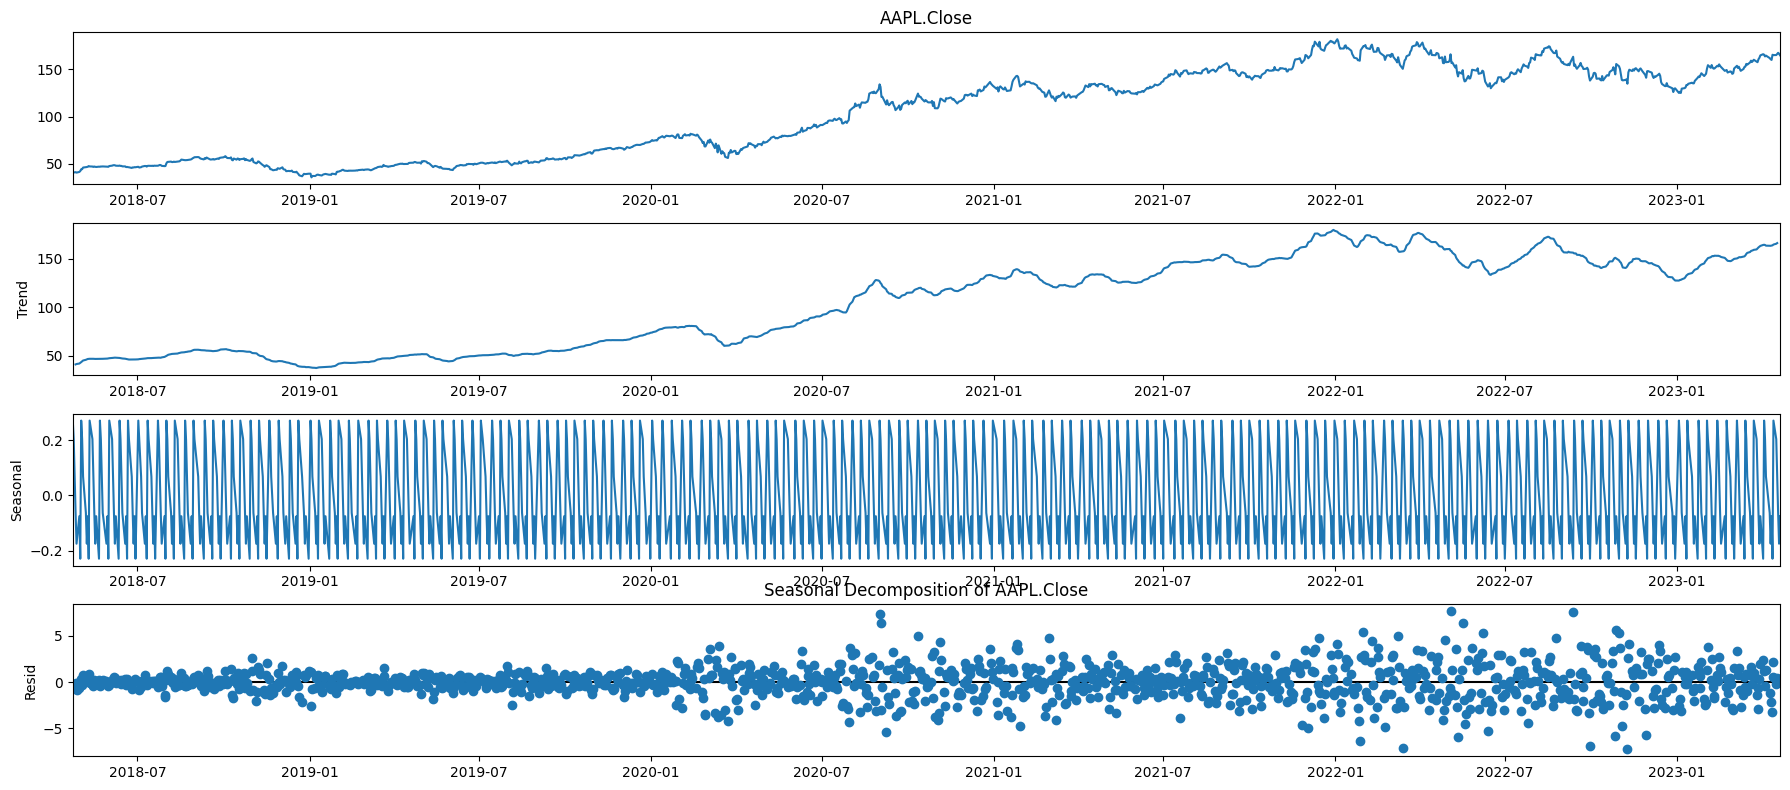

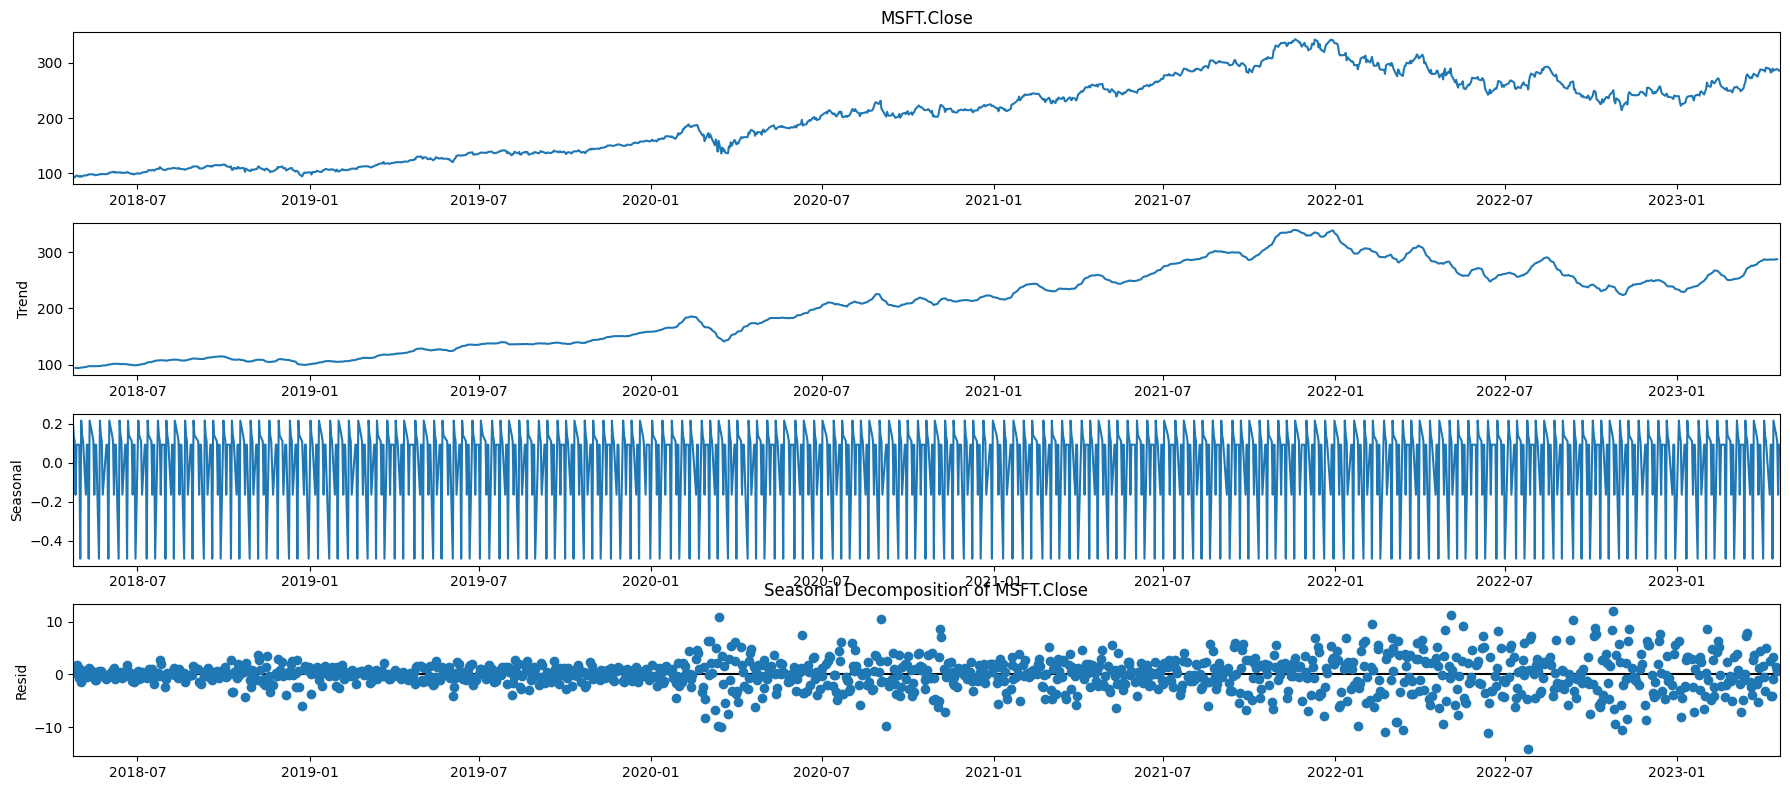

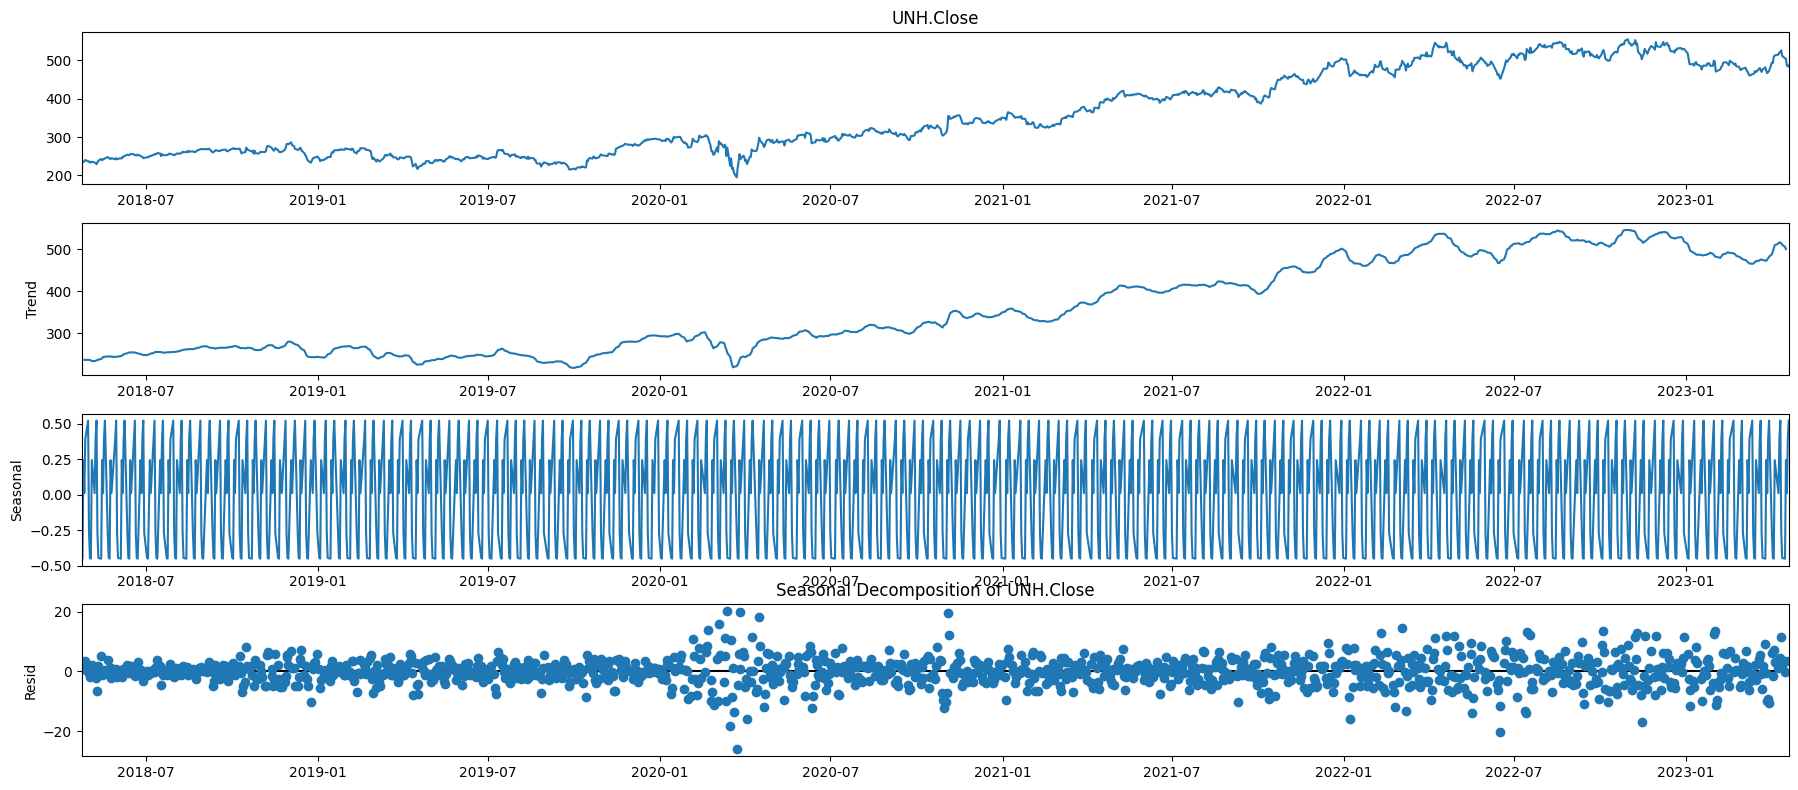

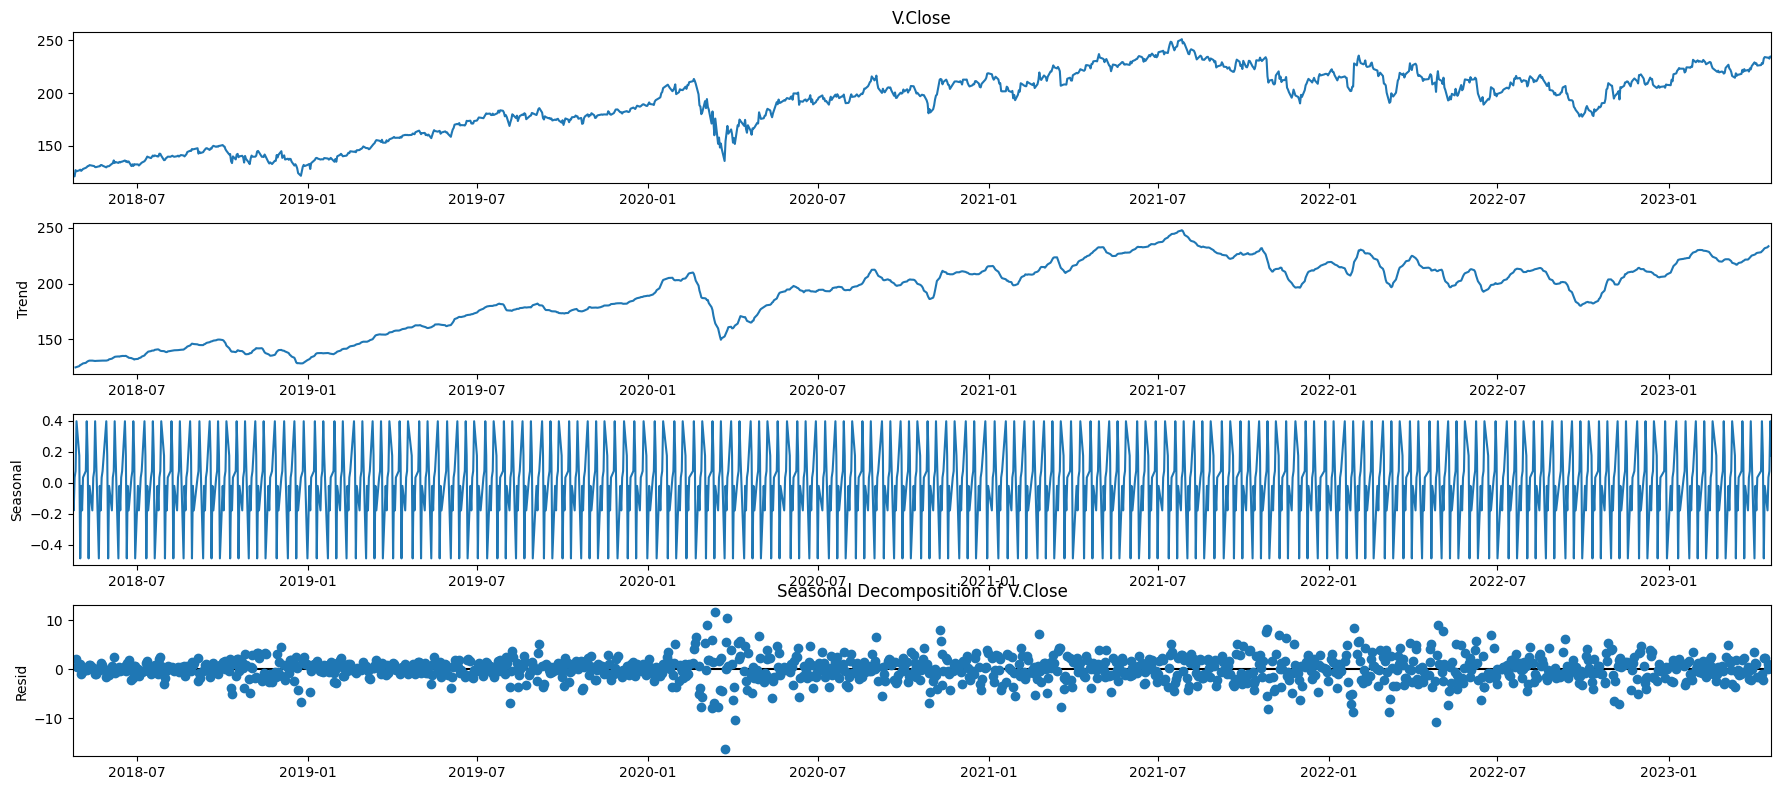

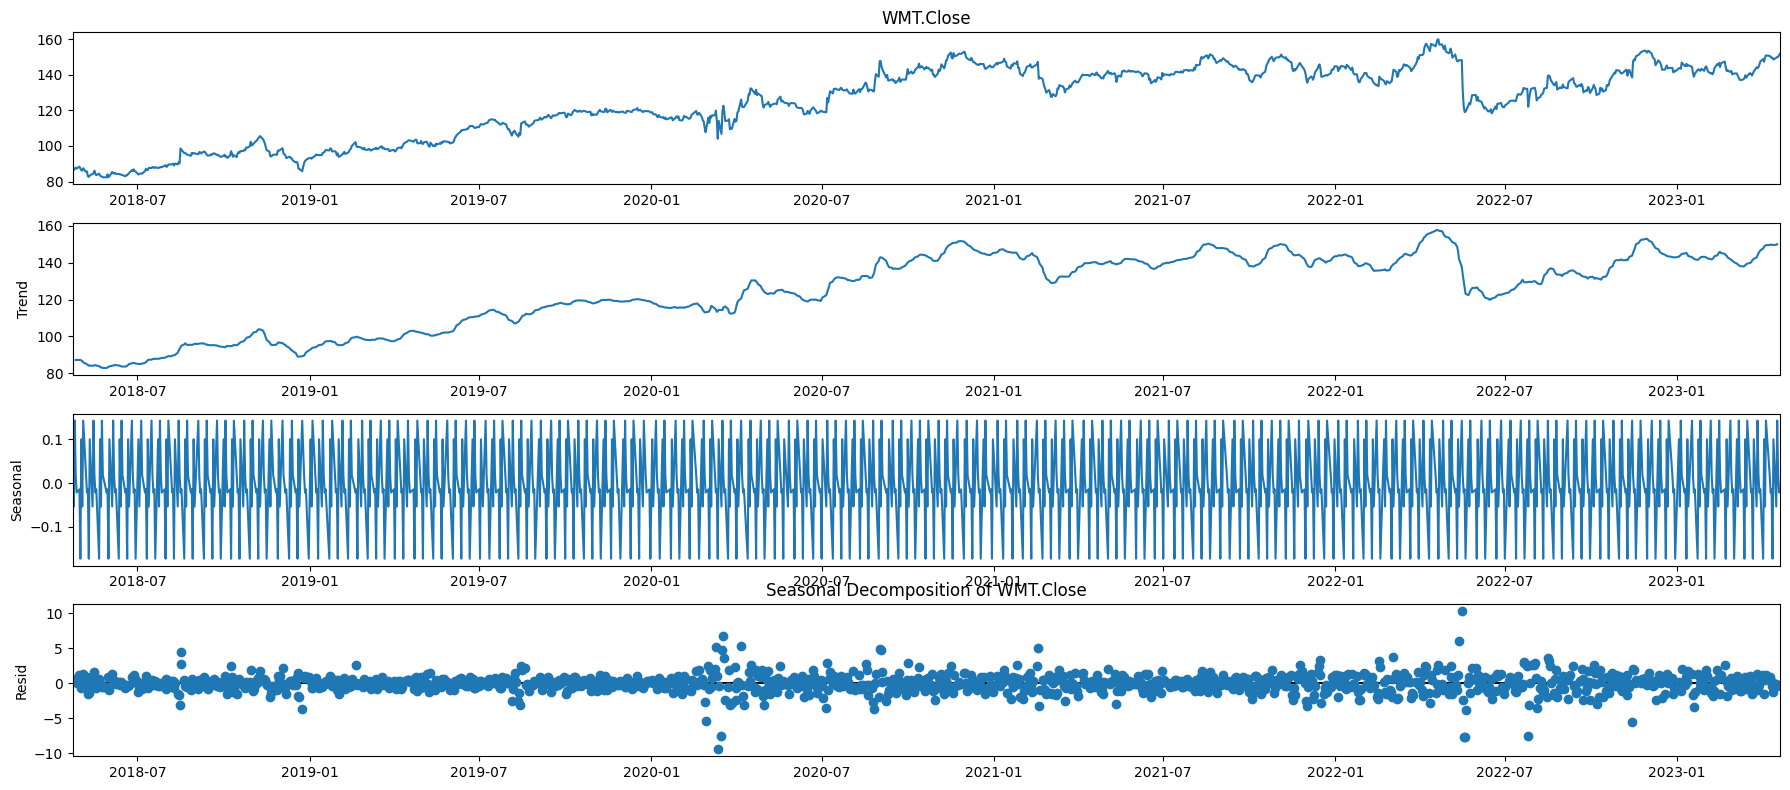

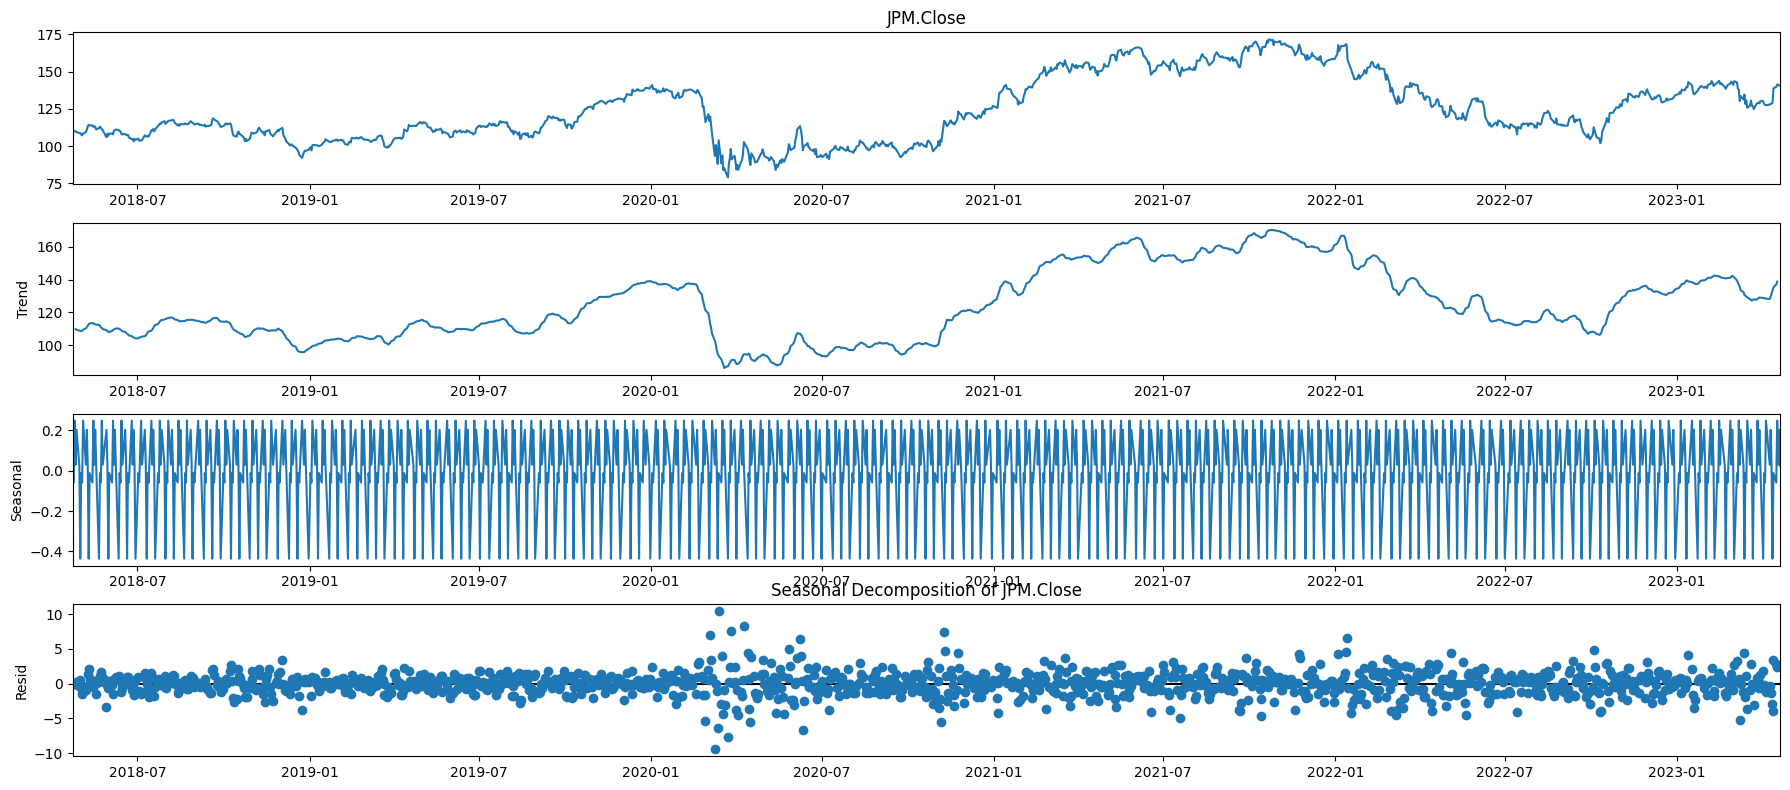

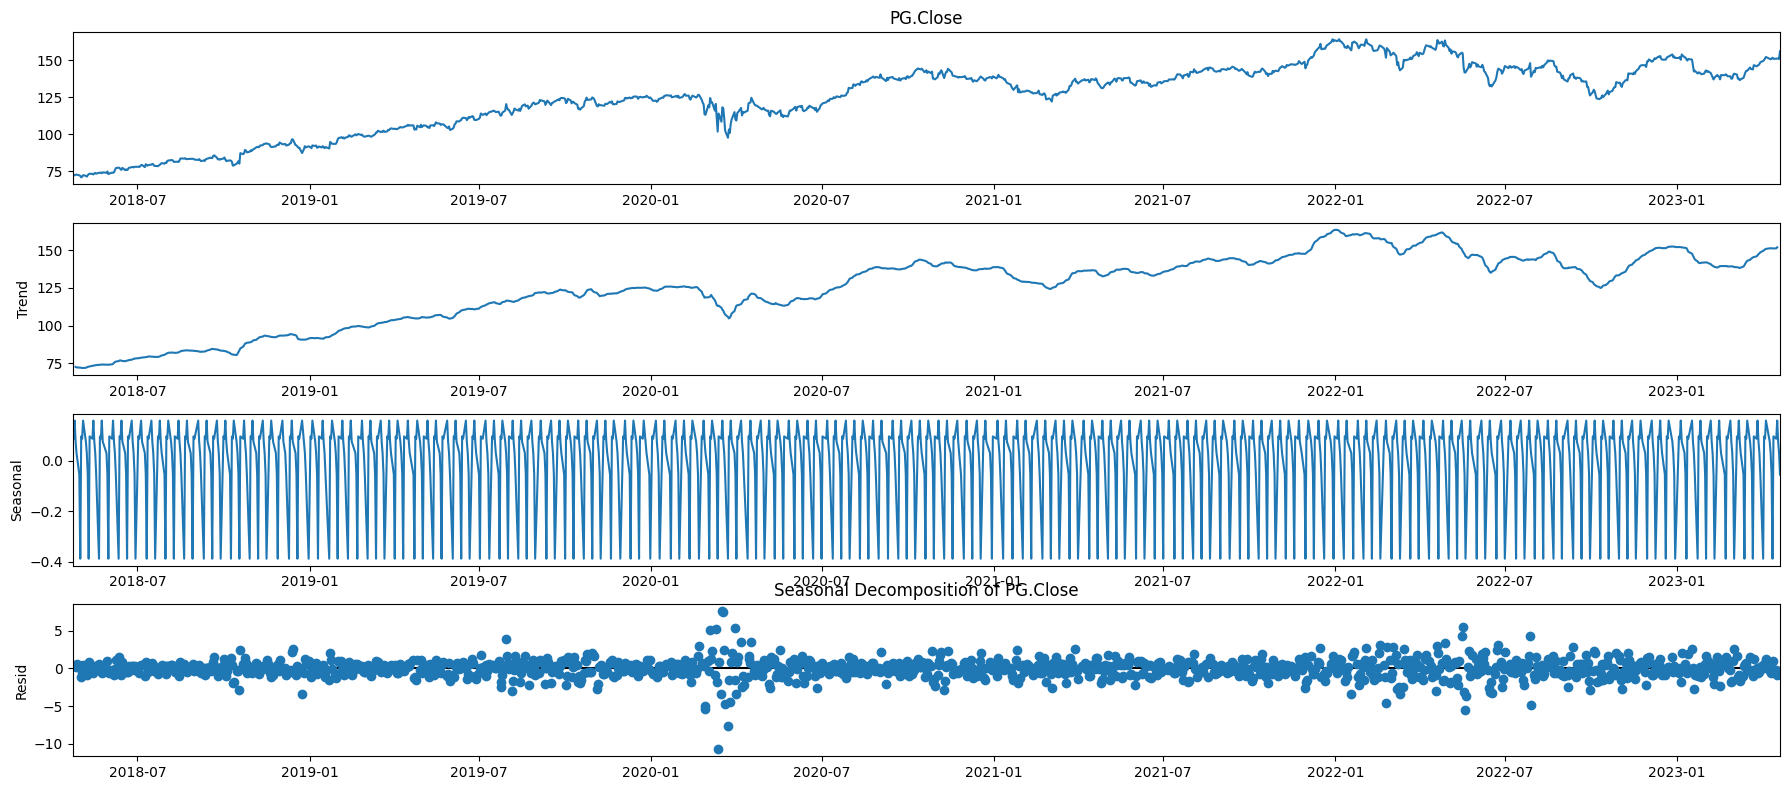

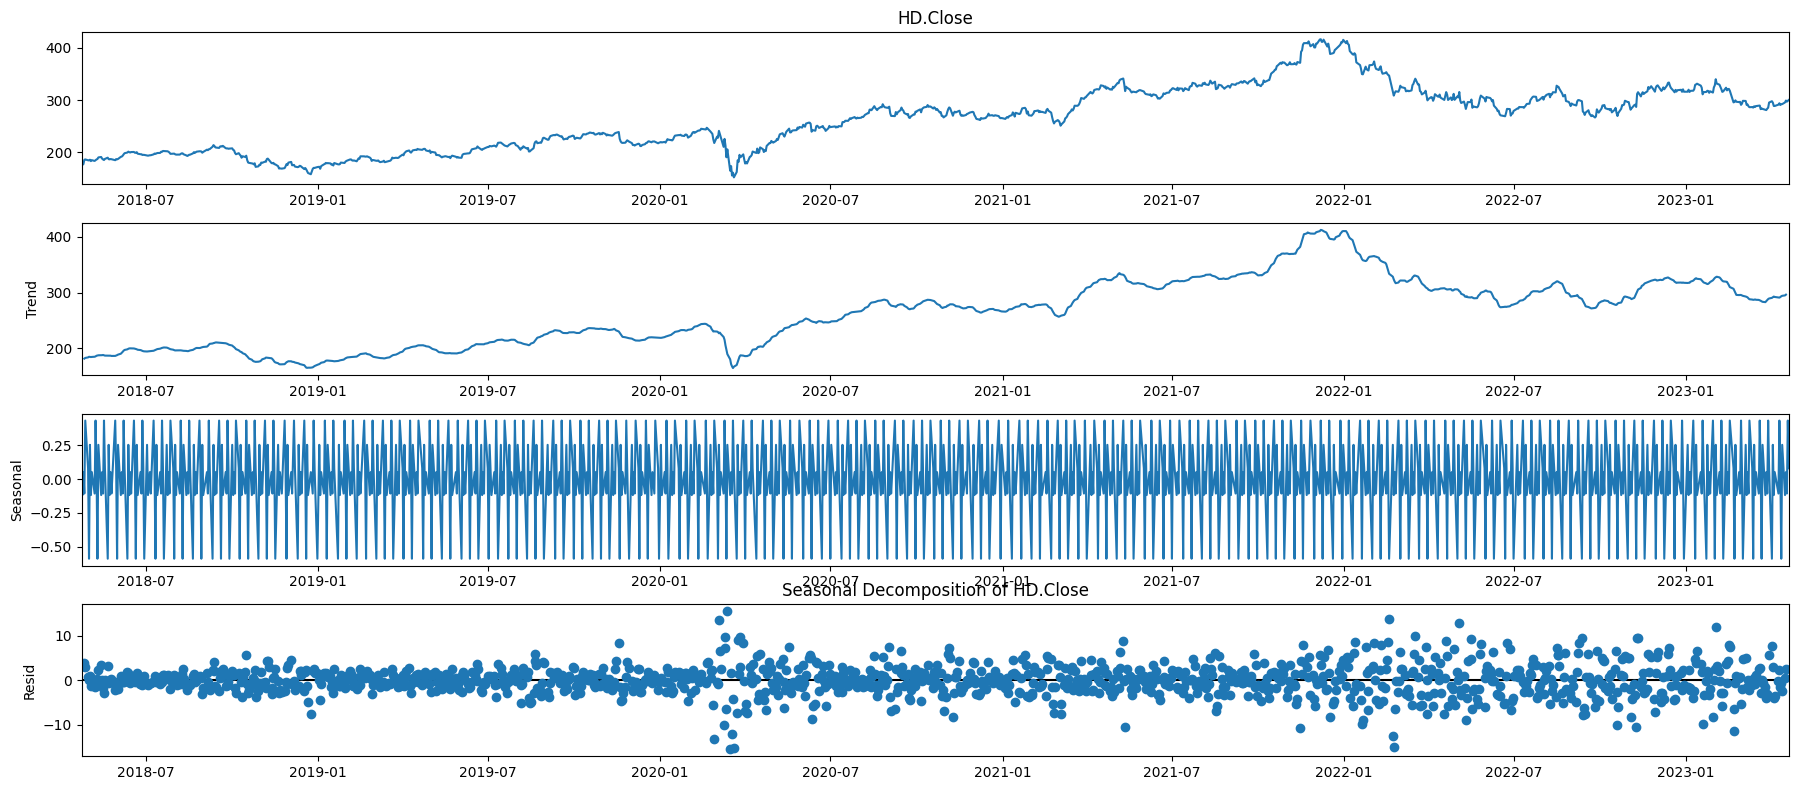

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
for col in stocks_cl.columns:
    # Perform the seasonal decomposition
    result = sm.tsa.seasonal_decompose(stocks_cl[col], model='additive', period=7)

    # Plot the seasonal decomposition
    fig = result.plot()
    plt.title('Seasonal Decomposition of {}'.format(col))
    plt.show()

Clearly the trends and the seasonality of the data are highly correlated across series' and there appears to be a cyclical component to the residuals.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
for col in stocks_cl.columns:
    print("Granger Causality Test for {}:".format(col))
    for col2 in stocks_cl.columns:
        if col != col2:
            test_result = grangercausalitytests(stocks_cl[[col, col2]], maxlag=5, verbose=False)
            print("{} -> {}: p-value = {:.4f}".format(col, col2, test_result[5][0]['ssr_ftest'][1]))
    print("")

Granger Causality Test for AAPL.Close:
AAPL.Close -> MSFT.Close: p-value = 0.0051
AAPL.Close -> UNH.Close: p-value = 0.0022
AAPL.Close -> V.Close: p-value = 0.0003
AAPL.Close -> WMT.Close: p-value = 0.3612
AAPL.Close -> JPM.Close: p-value = 0.0015
AAPL.Close -> PG.Close: p-value = 0.1777
AAPL.Close -> HD.Close: p-value = 0.1347

Granger Causality Test for MSFT.Close:
MSFT.Close -> AAPL.Close: p-value = 0.0008
MSFT.Close -> UNH.Close: p-value = 0.0010
MSFT.Close -> V.Close: p-value = 0.0000
MSFT.Close -> WMT.Close: p-value = 0.0380
MSFT.Close -> JPM.Close: p-value = 0.0038
MSFT.Close -> PG.Close: p-value = 0.0210
MSFT.Close -> HD.Close: p-value = 0.5250

Granger Causality Test for UNH.Close:
UNH.Close -> AAPL.Close: p-value = 0.0504
UNH.Close -> MSFT.Close: p-value = 0.2808
UNH.Close -> V.Close: p-value = 0.5573
UNH.Close -> WMT.Close: p-value = 0.3212
UNH.Close -> JPM.Close: p-value = 0.0535
UNH.Close -> PG.Close: p-value = 0.0138
UNH.Close -> HD.Close: p-value = 0.5750

Granger Causal

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#split test and train data
trends_cl = trends_cl.astype(float)

stocks_cl_test = stocks_cl.tail(30)
trends_cl_test = trends_cl.tail(30)

stocks_cl_train = stocks_cl.iloc[:-30]
trends_cl_train = trends_cl.iloc[:-30]


In [ ]:
#split melted data into train/test
melted_stocks_train = melted_stocks.iloc[:-(30*stocks_cl.shape[1])]
melted_trends_train = melted_trends.iloc[:-(30*trends_cl.shape[1])]

melted_stocks_test = melted_stocks.tail(30*stocks_cl.shape[1])
melted_trends_test = melted_trends.tail(30*trends_cl.shape[1])

In [ ]:
# set daily frequency
#stocks_cl_train = stocks_cl_train.asfreq('D')
#trends_cl_train = trends_cl_train.asfreq('D')

In [ ]:
# Fit a VARMAX model with seasonality
model = sm.tsa.VARMAX(stocks_cl_train, order=(1, 1), trend='c', exog=trends_cl_train, seasonal=True, seasonal_order=(7, 0))
results = model.fit(maxiter=100, disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pickle

filename = '/content/drive/MyDrive/varimax_trends.pickle'
with open(filename, 'wb') as file:
    pickle.dump(results, file)


# Load saved model from Google Drive
#with open('/content/drive/MyDrive/my_varimax_model.pkl', 'rb') as f:
    #model = pickle.load(f)

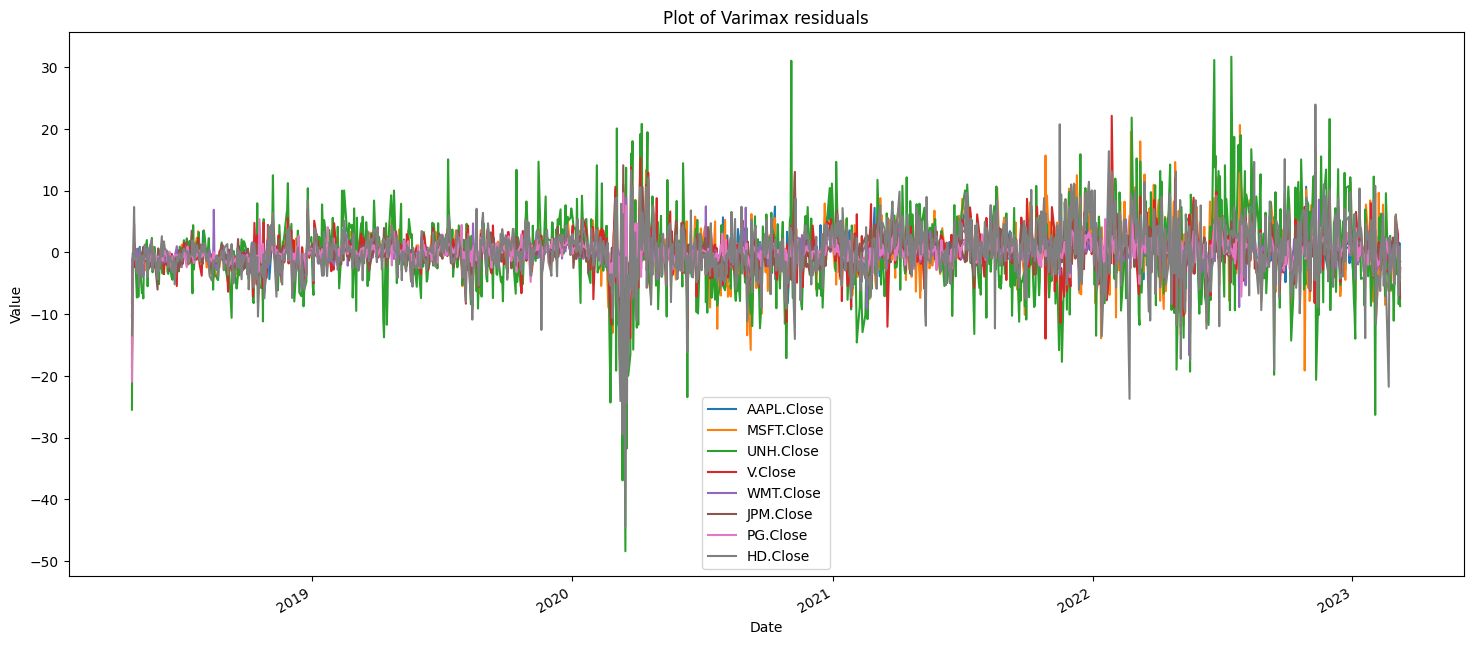

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
# Obtain the residuals from the fitted model
residuals = results.resid

ax = residuals.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Plot of Varimax residuals')

# Show the plot
plt.show()

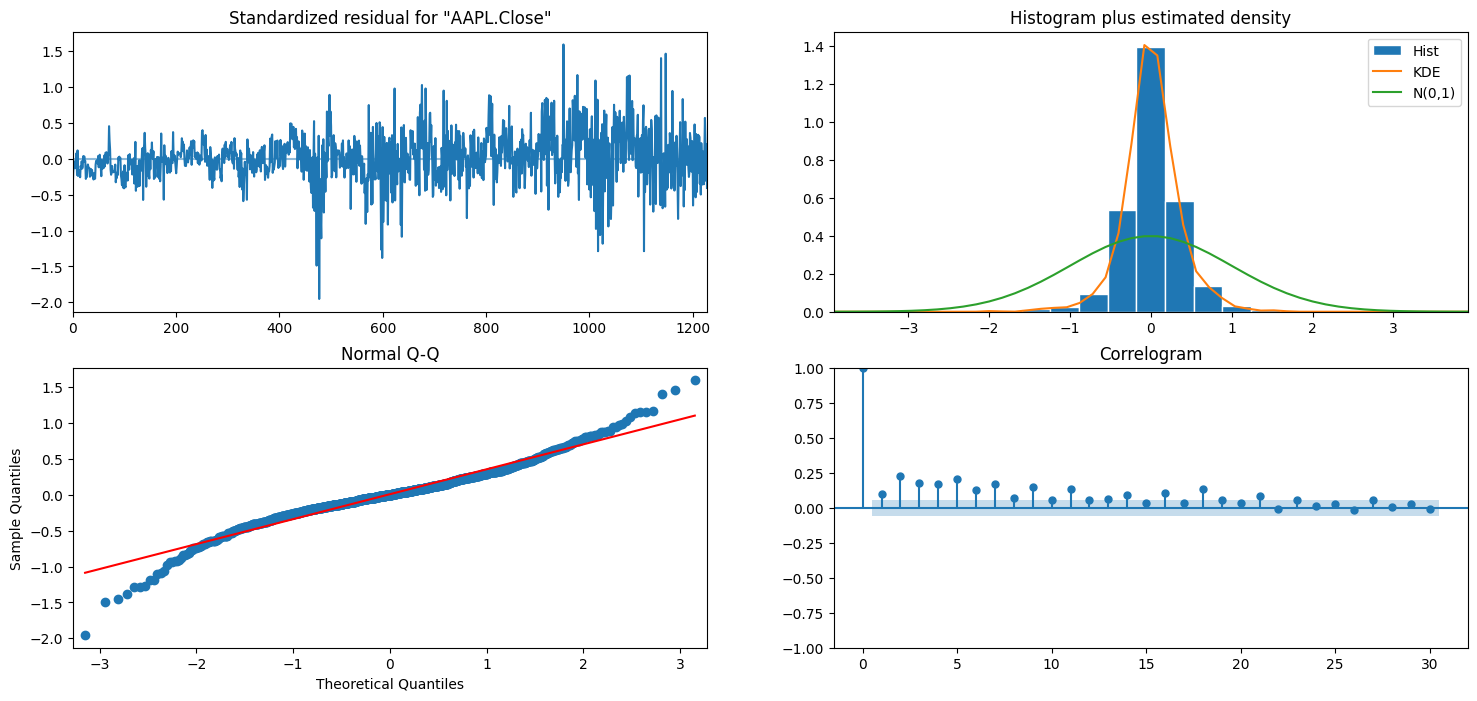

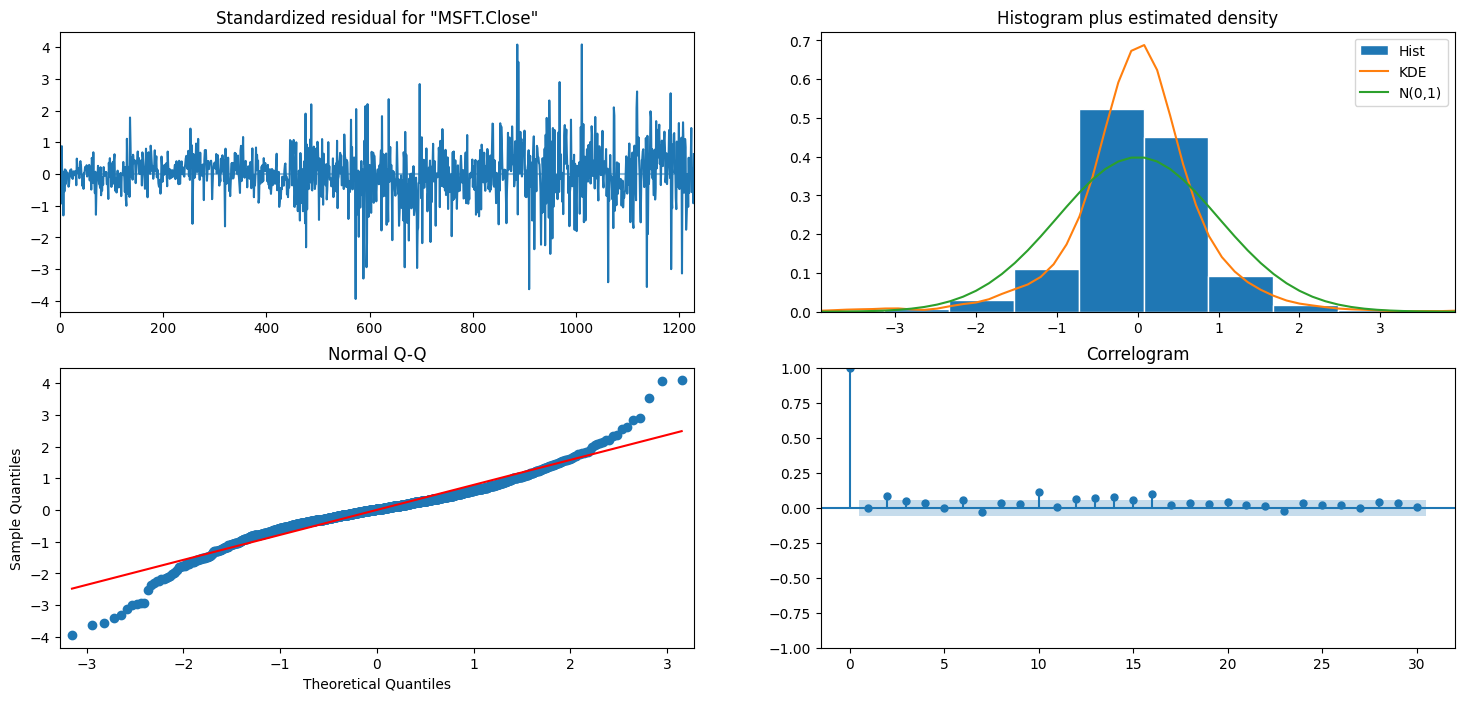

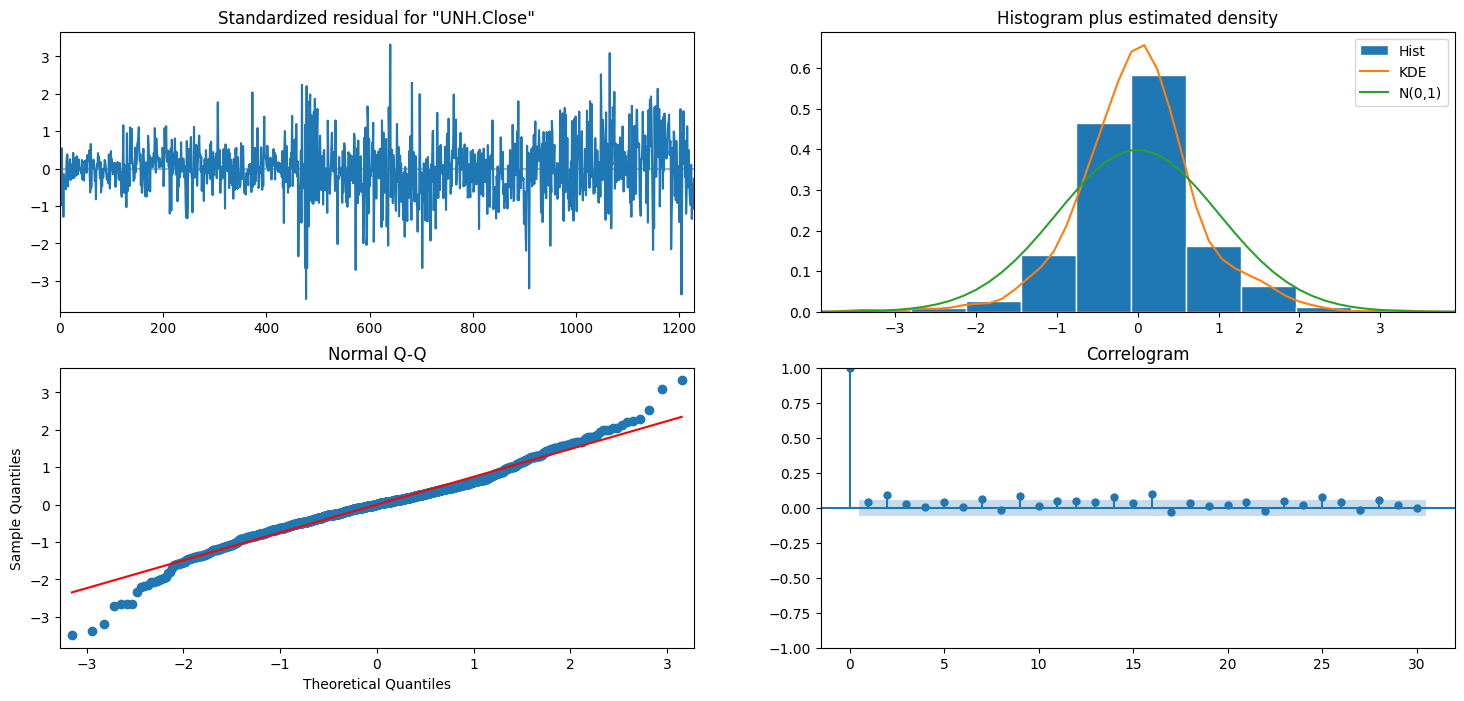

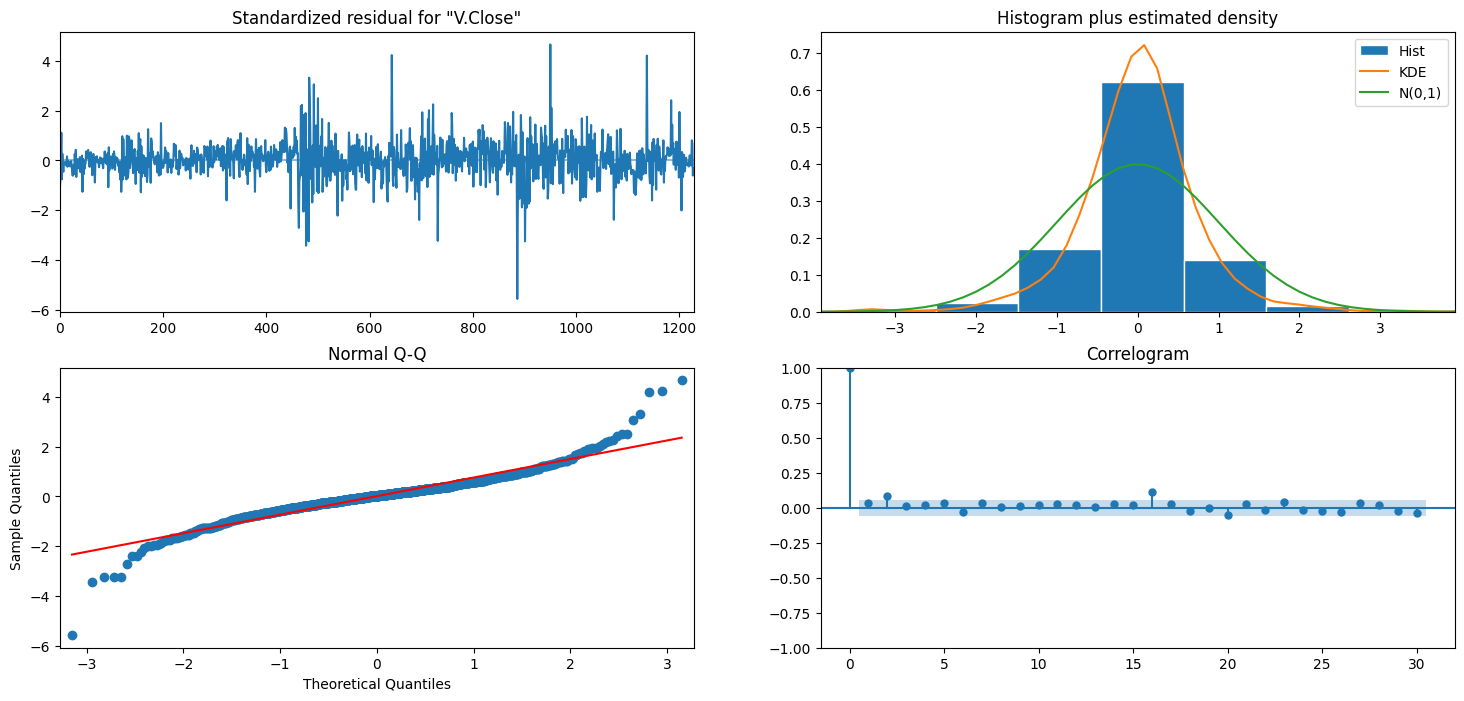

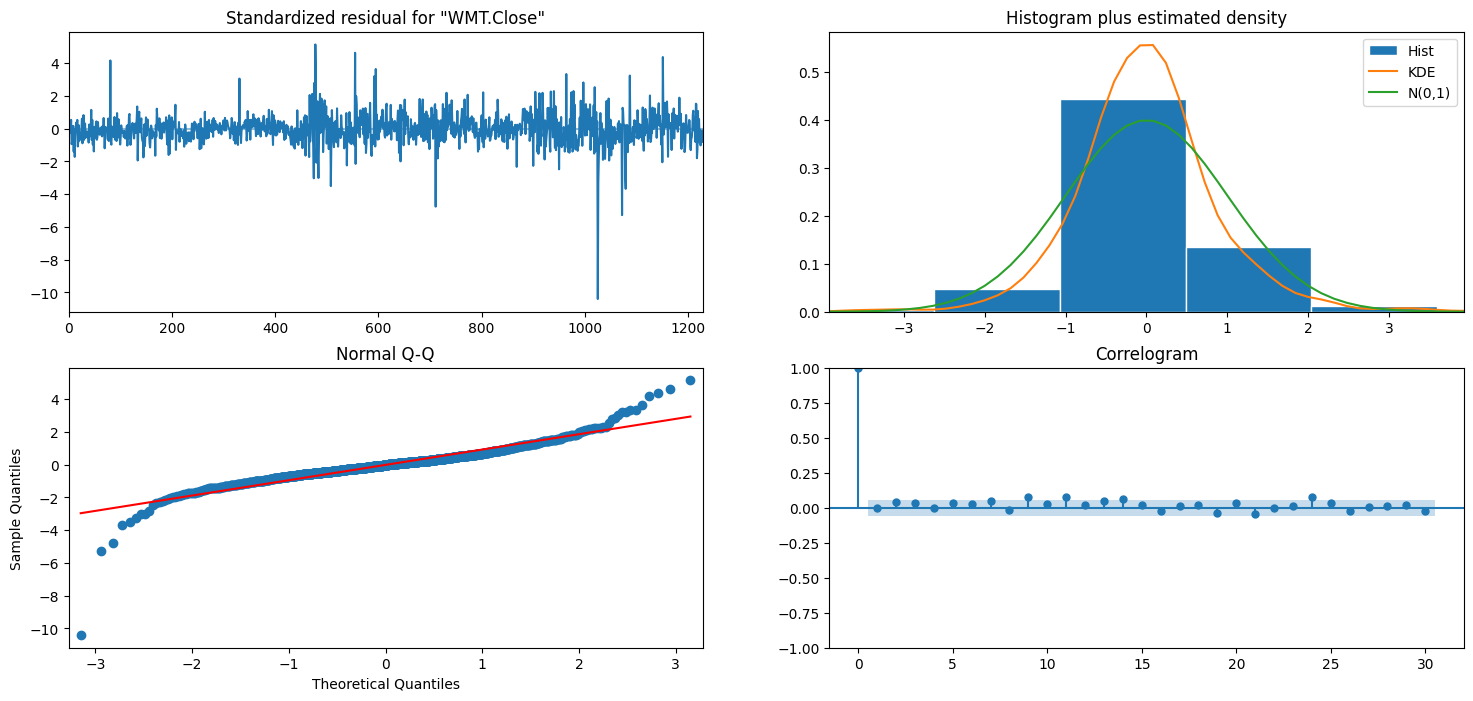

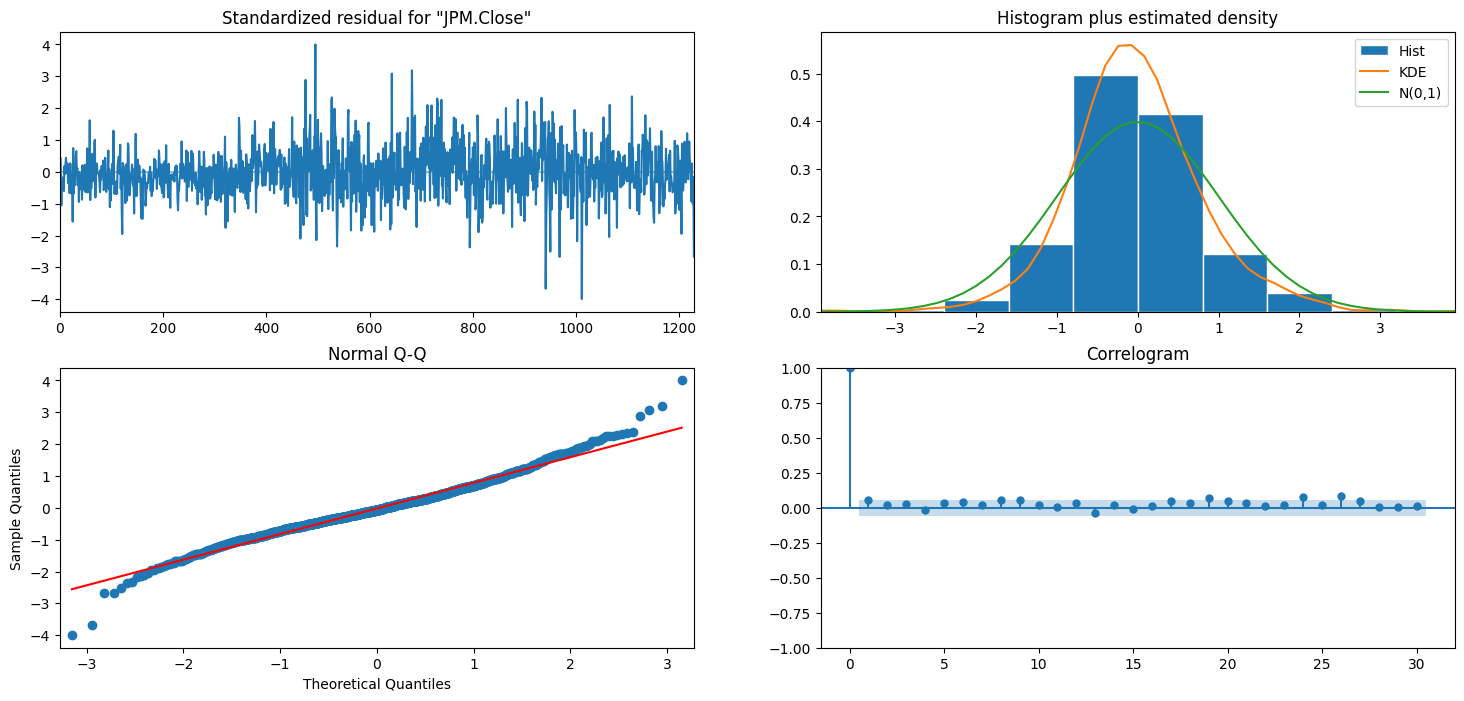

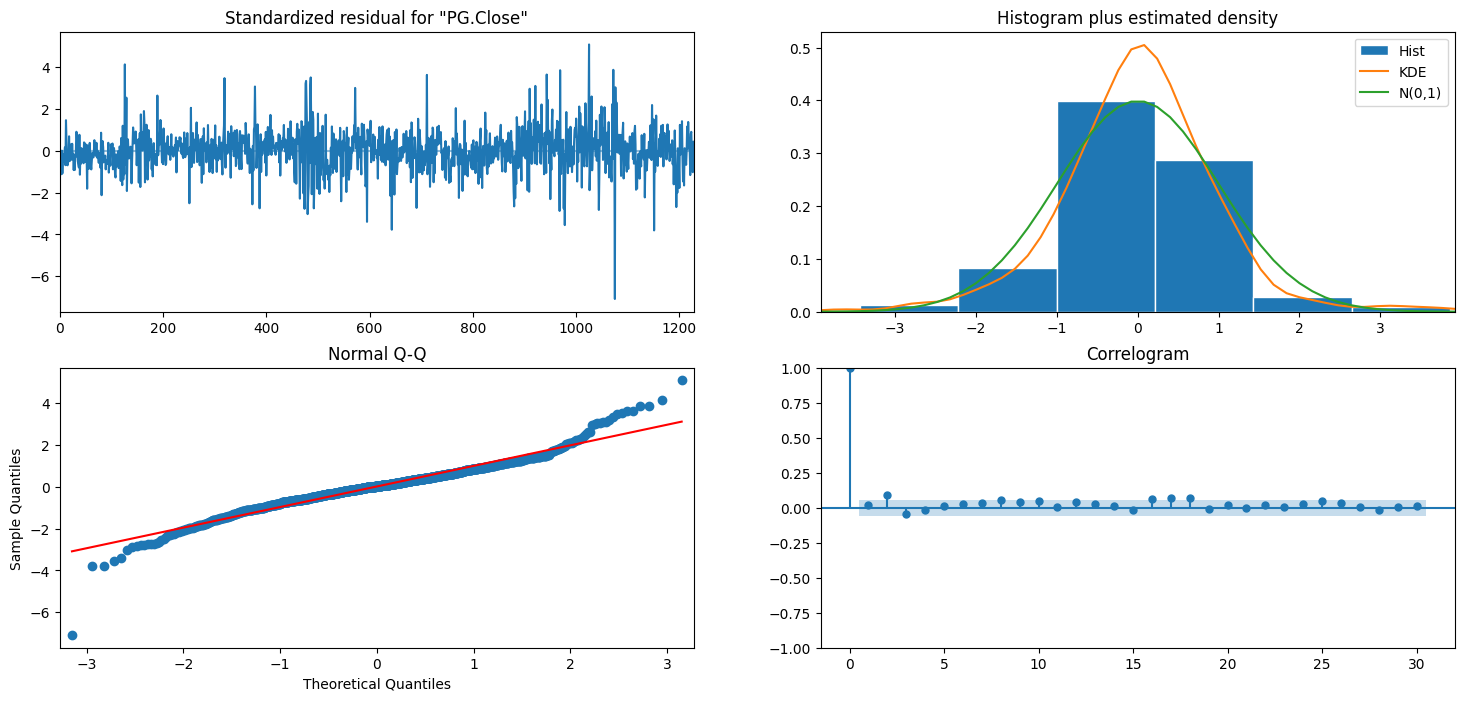

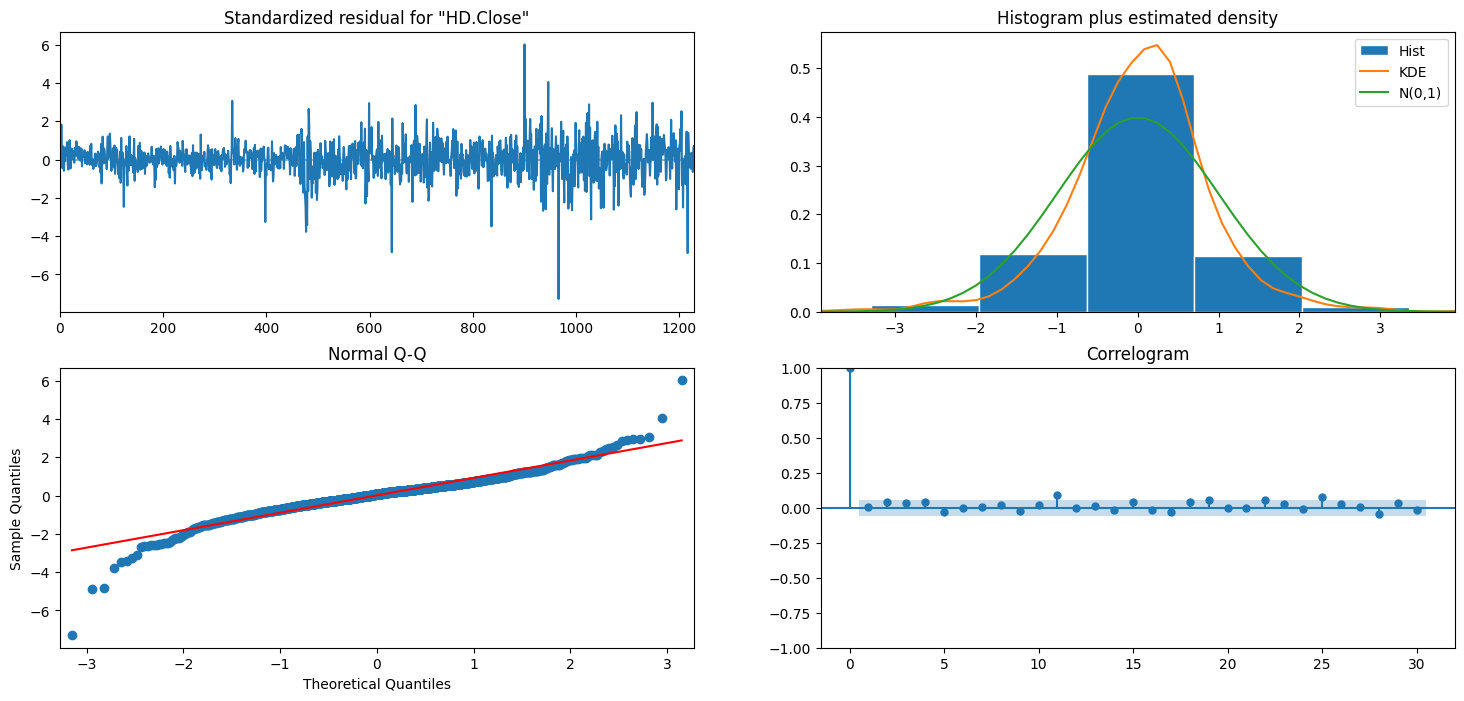

In [ ]:
for i in range(len(stocks_cl.columns)):
  results.plot_diagnostics(variable=i, lags=30)

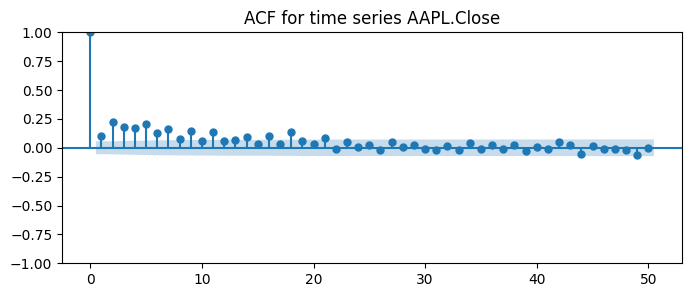

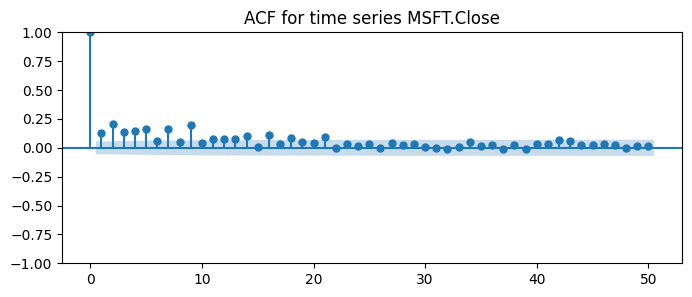

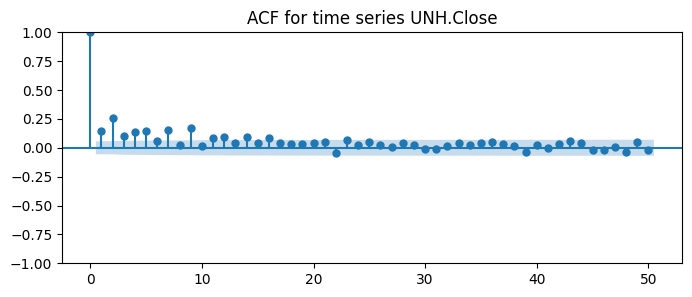

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(residuals[residuals.columns[0]], ax=ax, lags=50)
ax.set_title(f"ACF for time series {residuals.columns[0]}")
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(residuals[residuals.columns[1]], ax=ax, lags=50)
ax.set_title(f"ACF for time series {residuals.columns[1]}")
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(residuals[residuals.columns[2]], ax=ax, lags=50)
ax.set_title(f"ACF for time series {residuals.columns[2]}")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

pred = results.forecast(steps=30, exog=trends_cl_test)

print(pred)

print(stocks_cl_test)

mspe = []
for i in stocks_cl.columns:
    y_true = stocks_cl_test[i]
    y_pred = pred[i]
    mspe_i = mean_squared_error(y_true, y_pred)
    mspe.append(mspe_i)

# Print the MSPE for each series
for i, col in enumerate(stocks_cl.columns):
    print(f"{col} MSPE: {mspe[i]:.4f}")




      AAPL.Close  MSFT.Close   UNH.Close     V.Close   WMT.Close   JPM.Close  \
1229  150.646176  252.760368  467.451413  220.765811  137.628545  130.611247   
1230  149.771321  250.068200  472.973276  218.892301  137.545177  128.159272   
1231  148.853231  247.377528  477.596400  217.146617  137.409209  125.950983   
1232  147.903170  244.700094  481.425913  215.517485  137.229360  123.960094   
1233  146.930856  242.045838  484.555734  213.994757  137.013268  122.163145   
1234  145.944643  239.423126  487.069728  212.569294  136.767621  120.539205   
1235  146.606799  240.534582  487.785082  213.383657  137.355221  121.155971   
1236  147.234372  241.600482  488.506357  214.162923  137.913418  121.762240   
1237  147.828852  242.622591  489.229858  214.908522  138.443432  122.357642   
1238  148.391712  243.602646  489.952429  215.621828  138.946459  122.941835   
1239  148.924394  244.542350  490.671390  216.304162  139.423669  123.514514   
1240  146.951567  241.782789  487.291145

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Test performance of the model versus the estimator $x_{t-1}$ for $x_t$

In [ ]:
shift=stocks_cl.iloc[-31:-1, :]

mspe_shift = []
for i in stocks_cl.columns:
    y_true = stocks_cl_test[i]
    y_pred = shift[i]
    mspe_i = mean_squared_error(y_true, y_pred)
    mspe_shift.append(mspe_i)

# Print the MSPE for each series
for i, col in enumerate(stocks_cl.columns):
    print(f"{col} MSPE: {mspe_shift[i]:.4f}")


AAPL.Close MSPE: 3.6904
MSFT.Close MSPE: 19.5207
UNH.Close MSPE: 60.4833
V.Close MSPE: 4.8934
WMT.Close MSPE: 1.3041
JPM.Close MSPE: 8.2233
PG.Close MSPE: 2.0091
HD.Close MSPE: 9.5325


In [ ]:
print(np.sum(mspe))

print(np.sum(mspe_shift))

2865.4616709292636
109.65688016375307


Thus the VARIMAX model is outperformed by the simple $\hat x_{t} = x_{t-1}$ predictor.

In [ ]:
for col in residuals.columns:
    print("Granger Causality Test for {}:".format(col))
    for col2 in residuals.columns:
        if col != col2:
            test_result = grangercausalitytests(residuals[[col, col2]], maxlag=5, verbose=False)
            print("{} -> {}: p-value = {:.4f}".format(col, col2, test_result[5][0]['ssr_ftest'][1]))
    print("")

Granger Causality Test for AAPL.Close:
AAPL.Close -> MSFT.Close: p-value = 0.0022
AAPL.Close -> UNH.Close: p-value = 0.0001
AAPL.Close -> V.Close: p-value = 0.2906
AAPL.Close -> WMT.Close: p-value = 0.4983
AAPL.Close -> JPM.Close: p-value = 0.1574
AAPL.Close -> PG.Close: p-value = 0.0229
AAPL.Close -> HD.Close: p-value = 0.6157

Granger Causality Test for MSFT.Close:
MSFT.Close -> AAPL.Close: p-value = 0.0022
MSFT.Close -> UNH.Close: p-value = 0.0000
MSFT.Close -> V.Close: p-value = 0.0758
MSFT.Close -> WMT.Close: p-value = 0.4600
MSFT.Close -> JPM.Close: p-value = 0.6795
MSFT.Close -> PG.Close: p-value = 0.0235
MSFT.Close -> HD.Close: p-value = 0.3887

Granger Causality Test for UNH.Close:
UNH.Close -> AAPL.Close: p-value = 0.0045
UNH.Close -> MSFT.Close: p-value = 0.5638
UNH.Close -> V.Close: p-value = 0.5778
UNH.Close -> WMT.Close: p-value = 0.1889
UNH.Close -> JPM.Close: p-value = 0.0191
UNH.Close -> PG.Close: p-value = 0.0740
UNH.Close -> HD.Close: p-value = 0.0950

Granger Causal

Running the Granger Causality test on our model residuals indicates that the model still has not removed the cross corelations between our time series'

## Stan MBSTS model
We now run the stan mbsts model


In [ ]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
from pandas.core.frame import np_percentile_argname
import stan
import nest_asyncio

nest_asyncio.apply()

model_path = '/content/drive/MyDrive/mbsts.stan'
with open(model_path, 'r') as file:
    model_code = file.read()


# Set the values of the parameters
N_series = stocks_cl_train.shape[1]
N_periods = melted_stocks_train['period'].max()+1
N_features = trends_cl_train.shape[1]
N = melted_stocks_train.shape[0]
periods_to_predict = 30
ar = 3
p = 3
q = 3
N_seasonality = 2
s = [12, 274]
period_scale = N_periods*N_series
cyclicality_prior = 274
corr_prior = 1
period = melted_stocks_train['period'].values
period += 1

series = np.arange(N_series)
series+=1
series = np.tile(series, N//N_series)[:N]

# Convert the pandas data frames to numpy arrays
y = np.ravel(melted_stocks_train.drop(['period', 'stock'], axis=1).values.astype(float))
weight = np.ones(N)
x = trends_cl_train.values




# Define the data dictionary
data = {'N': N, 'N_series': N_series, 'N_periods': N_periods, 'N_features': N_features,'period': period,'series':series,
             'periods_to_predict': periods_to_predict, 'ar': ar, 'p': p, 'q': q,
             'N_seasonality': N_seasonality, 's': s, 'period_scale': period_scale,
             'cyclicality_prior': cyclicality_prior, 'corr_prior': corr_prior,
             'y': y, 'weight': weight, 'x': x}



In [ ]:
posterior = stan.build(model_code, data=data,random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_wb3nwgrg/model_ao5dz4bo.stan', line 51, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_wb3nwgrg/model_ao5dz4bo.stan', line 58, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_wb3nwgrg/model_ao5dz4bo.stan', line 59, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-for

In [ ]:
fit = posterior.sample(num_chains=4, num_samples=3000)

Sampling:   0%
Sampling:   0% (1/16000)
Sampling:   0% (2/16000)
Sampling:   1% (101/16000)
Sampling:   1% (200/16000)
Sampling:   2% (300/16000)
Sampling:   2% (400/16000)
Sampling:   3% (500/16000)
Sampling:   4% (600/16000)
Sampling:   4% (700/16000)
Sampling:   5% (800/16000)

In [ ]:
df = fit.to_frame()

In [ ]:
df.to_csv('mbsts_samples.csv')

In [ ]:
import pickle

with open("example_pickle.pickle", "wb") as f:
        pickle.dump({"model" : posterior, "fit" : fit}, f)

In [ ]:
## chain diagnostics

import arviz as az
az.plot_trace(fit)
summary = az.summary(fit)
print(summary)